## Reproducible code for a dot graph of tissue blocks per organ per consortium in CFDE

## Install and import libraries

In [1]:
%pip install requests pandas seaborn matplotlib numpy

import os
import csv
from pprint import pprint
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Define functions

In [2]:
def download_if_not_exists(url, folder):
    os.makedirs(folder, exist_ok=True)

    filename = os.path.basename(url.rstrip("/"))
    if not filename.lower().endswith(".csv"):
        filename += ".csv"

    filepath = os.path.join(folder, filename)

    # If file already exists
    if os.path.exists(filepath):
        print(f"File already exists: {filepath}")
        return filepath

    # Download file
    response = requests.get(url)
    response.raise_for_status()

    with open(filepath, "wb") as f:
        f.write(response.content)

    print(f"Downloaded file: {filepath}")
    return filepath

## Load data from HRA API

In [3]:
# tissue_blocks_json = download_if_not_exists("https://apps.humanatlas.io/api/v1/ds-graph", "data")
datasets_csv = download_if_not_exists(
    "https://grlc.io/api-git/hubmapconsortium/ccf-grlc/subdir/hra/datasets-list-organs-providers.csv",
    "downloads",
)
datasets_csv

File already exists: downloads\datasets-list-organs-providers.csv


'downloads\\datasets-list-organs-providers.csv'

## Load as `df`


In [4]:
cfde_efforts = ["HuBMAP", "SenNet", "GTEx", "SPARC", "HTAN"]

In [5]:
df = pd.read_csv("downloads/datasets-list-organs-providers.csv")
df

,dataset,organ_iri,organ,consortium,tissue_provider
0,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/sig/ont/fma/fma24978,left knee,HuBMAP,CHOP
1,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/sig/ont/fma/fma24978,left knee,HuBMAP,CHOP
2,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/sig/ont/fma/fma24978,left knee,HuBMAP,CHOP
3,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/sig/ont/fma/fma24978,left knee,HuBMAP,CHOP
4,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/sig/ont/fma/fma24978,left knee,HuBMAP,CHOP
...,...,...,...,...,...
8107,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania
8108,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania
8109,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania
8110,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania


## Get counts

In [6]:
df["dataset"].nunique()

8062

In [7]:
# Number opf unique datasets
df.groupby("consortium")["dataset"].nunique().reset_index(name="unique_dataset_count")

,consortium,unique_dataset_count
0,<Consortium Name>,106
1,Allen Institute for Brain Science,10
2,GTEx,50
3,GUDMAP,12
4,HCA,221
5,"HIRN, ESPACE",1
6,HRA,1
7,HTAN,31
8,HuBMAP,5059
9,KPMP,405


In [8]:
# Count unique datasets by organ and consortium
df_count = (
    df.groupby(["organ", "consortium"])["dataset"]
    .nunique()
    .reset_index(name="unique_dataset_count")
)
df_count

,organ,consortium,unique_dataset_count
0,blood vasculature,GTEx,2
1,brain,Allen Institute for Brain Science,10
2,brain,SenNet,300
3,heart,GTEx,10
4,heart,HCA,129
...,...,...,...
74,thymus,HuBMAP,60
75,urinary bladder,HCA,6
76,urinary bladder,HuBMAP,28
77,uterus,GTEx,1


## Clean and preprocess data 
`organ, provider_name, count`

In [9]:
# Clean organ labels
df_count["organ"] = df_count["organ"].apply(
    lambda organ: "skin" if "of body" in organ else organ
)

df_count.loc[df_count["organ"] == "male reproductive system", "organ"] = "prostate"
df_count.loc[
    df_count["organ"] == "set of lactiferous glands in left breast", "organ"
] = "left breast"
df_count.loc[
    df_count["organ"] == "set of lactiferous glands in right breast", "organ"
] = "right breast"
df_count

,organ,consortium,unique_dataset_count
0,blood vasculature,GTEx,2
1,brain,Allen Institute for Brain Science,10
2,brain,SenNet,300
3,heart,GTEx,10
4,heart,HCA,129
...,...,...,...
74,thymus,HuBMAP,60
75,urinary bladder,HCA,6
76,urinary bladder,HuBMAP,28
77,uterus,GTEx,1


In [10]:
df["organ"].unique()

array(['left knee', 'right knee',
       'set of lactiferous glands in left breast',
       'set of lactiferous glands in right breast', 'blood vasculature',
       'brain', 'heart', 'large intestine', 'left eye',
       'left fallopian tube', 'left kidney', 'left ovary', 'left ureter',
       'liver', 'male reproductive system', 'mesenteric lymph node',
       'pancreas', 'placenta', 'respiratory system', 'right eye',
       'right fallopian tube', 'right kidney', 'right ovary',
       'right ureter', 'skin of body', 'small intestine', 'spleen',
       'thymus', 'urinary bladder', 'uterus'], dtype=object)

In [11]:
# Make organs upper case
df_count["organ"] = df_count["organ"].str.capitalize()
df_count

,organ,consortium,unique_dataset_count
0,Blood vasculature,GTEx,2
1,Brain,Allen Institute for Brain Science,10
2,Brain,SenNet,300
3,Heart,GTEx,10
4,Heart,HCA,129
...,...,...,...
74,Thymus,HuBMAP,60
75,Urinary bladder,HCA,6
76,Urinary bladder,HuBMAP,28
77,Uterus,GTEx,1


In [12]:
# Filter
df_count.loc[~df_count["consortium"].isin(cfde_efforts), "consortium"] = "Other"

df_visualize = df_count.sort_values("organ")
df_visualize

,organ,consortium,unique_dataset_count
0,Blood vasculature,GTEx,2
1,Brain,Other,10
2,Brain,SenNet,300
3,Heart,GTEx,10
4,Heart,Other,129
...,...,...,...
74,Thymus,HuBMAP,60
75,Urinary bladder,Other,6
76,Urinary bladder,HuBMAP,28
77,Uterus,GTEx,1


## Visualize

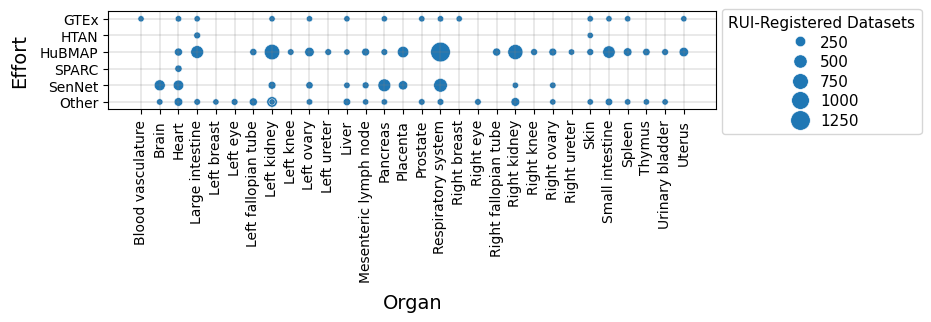

In [13]:
# prepare alphabetical order with 'Other' last
order = sorted(df_visualize["consortium"].unique())
order = [x for x in order if x != "Other"] + (["Other"] if "Other" in order else [])

# enforce categorical ordering in the dataframe
df_visualize["consortium"] = pd.Categorical(
    df_visualize["consortium"],
    categories=order,
    ordered=True,
)

# Create the scatter plot (DO NOT pass order= to scatterplot)
g = sns.scatterplot(
    data=df_visualize,
    x="organ",
    y="consortium",
    size="unique_dataset_count",
    sizes=(20, 200),
    legend="brief",
)

# (Optional) ensure y-ticks match the category order exactly
g.set_yticks(range(len(order)))
g.set_yticklabels(order)

# Set white background for figure and axes
g.figure.set_facecolor("white")
g.set_facecolor("white")

# Set thin grey grid lines
g.grid(True, which="major", axis="both", linestyle="-", linewidth=0.25, color="grey")

# increase figure size to accommodate facet grid
g.figure.set_size_inches(10, 3.5)

# Adjust spacing on x / Add vertical padding
g.margins(x=0.06)
g.margins(y=0.09)

# Customize the plot
plt.xlabel("Organ", labelpad=8, fontsize=14)
plt.ylabel("Effort", labelpad=8, fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# adjust legend
legend = g.legend(
    title="RUI-Registered Datasets",
    loc="upper right",
    labelspacing=0.3,
    fontsize=11,
    title_fontsize=11,
    bbox_to_anchor=(1.35, 1.1),
    handletextpad=0.3,
)

plt.tight_layout()
plt.savefig(
    "output/datasets-per-organ-per-effort.pdf",
    dpi=600,
    format="pdf",
    bbox_inches="tight",
)
plt.show()